In [1]:
import numpy as np
from scipy.linalg import eigh
from scipy.sparse import csr_matrix, kron
from scipy.sparse.linalg import expm_multiply
from scipy.linalg import expm

import random
from qutip import Qobj, mesolve

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm, ticker, colors
from scipy.optimize import curve_fit

from numpy.random import choice
from scipy.special import binom

In [2]:
rc = {"font.family" : "serif", "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

# Stark hamiltonian

In [3]:
# Define Stark Hamiltonian
def SP_hamiltonian(N, J, h0):
    H=np.zeros((N,N))
    for i in range(N-1):
        H[i,i+1] = J;
        H[i+1,i] = J;
    for i in range(N):
        H[i,i] = (i+1)*(h0)
    return H


In [4]:
# Unitary time evolution of initial state
def SP_timePsi(N,J,h0,t,N_t):
    H= SP_hamiltonian(N,J,h0)
    
    Psi_0_t=np.zeros(N);
    m= int(N/2)
    
    Psi_0_t[m]=1;
    Psi_t= []
    for ti in range(0,N_t):
        Psi_t.append(expm(-1j*H*t[ti]) @ Psi_0_t);
    return Psi_t

## 
$QFI(h0)=4 \chi \\
F= |\braket{\phi_0(h_0)|\phi_0(h_0+\delta h_0)}|=1-\frac{1}{2} (\delta h_0)^2 \chi $


In [5]:
# Unitary time evolution of the QFI
def SP_timeQFI(N,J,h0,d_h0,t,N_t):
    Psi_t = SP_timePsi(N,J,h0,t,N_t)
    d_Psi_t = SP_timePsi(N,J,h0+d_h0,t,N_t)
    QFI_t= np.zeros(N_t);
    for ti in range(N_t):
        F = np.dot(np.transpose(d_Psi_t[ti]).conj(),Psi_t[ti]);
        QFI_t[ti]= 4*(1-np.abs(F.conj()*F))/ d_h0**2
    return QFI_t

In [52]:
J = -1; delta_t = 1; T = 1000;
N_t= int(T/delta_t); t=np.linspace(1,T,N_t);

In [53]:
N = 100; 
d_h0=.00001;
h0 =.01; 
QFI_01 = SP_timeQFI(N,J,h0,d_h0,t,N_t)
h0 =.08; 
QFI_08 = SP_timeQFI(N,J,h0,d_h0,t,N_t)
h0 =.5; 
QFI_5 = SP_timeQFI(N,J,h0,d_h0,t,N_t)


In [70]:
def fitting(x,a,b):
    return a* x**b 
x_fit = np.linspace(1, 20, 20);
fitplot , _ = curve_fit(fitting,x_fit,QFI_01[0:20]);
a,b = fitplot
print(a,b)

2.0143335423853137 3.9968879730169005


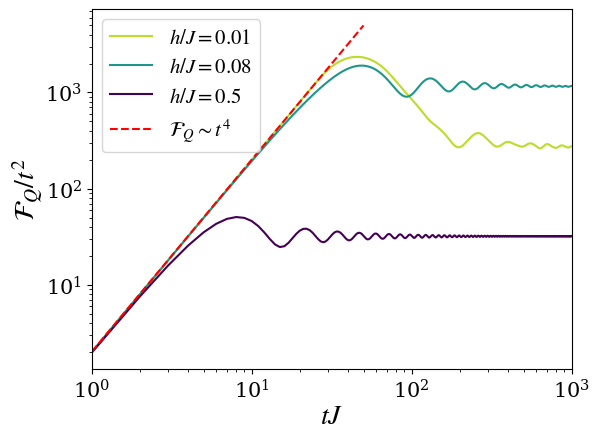

In [72]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(t,np.array(QFI_01)/t**2,'-', label='$h/J= 0.01$', color=colors[17])
plt.plot(t,np.array(QFI_08)/t**2,'-', label='$h/J= 0.08$', color=colors[10])
plt.plot(t,np.array(QFI_5)/t**2,'-', label='$h/J= 0.5$', color=colors[0])

t_fit = np.linspace(1, 50, 50-1);
plt.plot(t_fit,a* t_fit**b/t_fit**2, '--', label='$\mathcal{F}_{Q} \sim t^{4}$', color='r')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,1000)
plt.xlabel("$tJ$",fontsize=20, labelpad= 0)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=20, labelpad=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(loc='upper left',fontsize= '15')
plt.show()


In [46]:
n_site= 14;
Num= [
      20, 40, 60, 80, 100, 120, 140, 160, 180, 200,
      250, 300, 350, 400
      ]
h0= [
      .011, .012, .013, .014, .015, .016, .017, .018, .019,
      .02, .025, 
      .03, .04, .05, .06, .07, .08, .09,
      .1, .15, .2, .25, .3, .35, .4, .45, .5, .55, .6, .65, .7, .75, .8, .85, .9, .95, 1
      ]
n_h0= 37;

In [74]:
# to speed up the calculation use the time period:
#t=np.linspace(1000,T,1); N_t=1;
QFIh0N = np.zeros((n_site,n_h0))
for nu in range(0,n_site):
        for el0 in range(0,n_h0):
                QFI= SP_timeQFI(int(Num[nu]),J,h0[el0],d_h0,t,N_t)
                QFIh0N[nu,el0]= QFI[N_t-1]
        # print('nu=',nu)


In [67]:
def fitting(x,a,b):
    return a* x**b 
x_fit = h0[20:n_h0];
fitplot , _ = curve_fit(fitting,x_fit,QFIh0N[4,20:n_h0]);
a,b= fitplot
print(a,b)

7990520.391730323 -2.0051312622739323


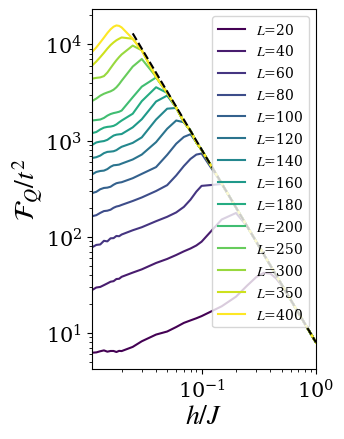

In [72]:
colors = plt.colormaps.get_cmap('viridis').resampled(14).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, .35, .75])
axes1.plot(h0,QFIh0N[0,:]/T**2,'-',label='$L$=20', color=colors[0])
axes1.plot(h0,QFIh0N[1,:]/T**2,'-',label='$L$=40', color=colors[1])
axes1.plot(h0,QFIh0N[2,:]/T**2,'-',label='$L$=60', color=colors[2])
axes1.plot(h0,QFIh0N[3,:]/T**2,'-',label='$L$=80', color=colors[3])
axes1.plot(h0,QFIh0N[4,:]/T**2,'-',label='$L$=100', color=colors[4])
axes1.plot(h0,QFIh0N[5,:]/T**2,'-',label='$L$=120', color=colors[5])
axes1.plot(h0,QFIh0N[6,:]/T**2,'-',label='$L$=140', color=colors[6])
axes1.plot(h0,QFIh0N[7,:]/T**2,'-',label='$L$=160', color=colors[7])
axes1.plot(h0,QFIh0N[8,:]/T**2,'-',label='$L$=180', color=colors[8])
axes1.plot(h0,QFIh0N[9,:]/T**2,'-',label='$L$=200', color=colors[9])
axes1.plot(h0,QFIh0N[10,:]/T**2,'-',label='$L$=250', color=colors[10])
axes1.plot(h0,QFIh0N[11,:]/T**2,'-',label='$L$=300', color=colors[11])
axes1.plot(h0,QFIh0N[12,:]/T**2,'-',label='$L$=350', color=colors[12])
axes1.plot(h0,QFIh0N[13,:]/T**2,'-',label='$L$=400', color=colors[13])

x_fit = np.array(h0[10:n_h0]);
plt.plot(x_fit,a* x_fit**b/T**2,'--',color='k' )

plt.xscale('log')
plt.yscale('log')
plt.xlim(.011,1)


# Naming the x-axis, y-axis 1and the whole graph
plt.xlabel("$h/J$",fontsize=20, labelpad= 0)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=20, labelpad=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
axes1.legend(loc='upper right', fontsize= 10)
plt.show()


In [75]:
MaxQFIh0N= [
            max(QFIh0N[0,:]), max(QFIh0N[1,:]), max(QFIh0N[2,:]), max(QFIh0N[3,:])
            , max(QFIh0N[4,:]), max(QFIh0N[5,:]), max(QFIh0N[6,:]), max(QFIh0N[7,:])
            , max(QFIh0N[8,:]), max(QFIh0N[9,:]), max(QFIh0N[10,:])
            , max(QFIh0N[11,:]), max(QFIh0N[12,:]), max(QFIh0N[13,:])
            ]

In [76]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num[0:n_site-5]
fitplot , _ = curve_fit(fitting,x_fit,np.array(MaxQFIh0N[0:n_site-5])/T**2);
aNMax,bNMax = fitplot
print(aNMax,bNMax)

0.12499389720263841 1.9789413882786837


In [77]:
frsQFIh0N= [(QFIh0N[0,0]), (QFIh0N[1,0]), (QFIh0N[2,0]), (QFIh0N[3,0])
            , (QFIh0N[4,0]), (QFIh0N[5,0]), (QFIh0N[6,0]), (QFIh0N[7,0])
            , (QFIh0N[8,0]), (QFIh0N[9,0]), (QFIh0N[10,0])
            , (QFIh0N[11,0]), (QFIh0N[12,0]), (QFIh0N[13,0])
            ]

In [78]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num
fitplot , _ = curve_fit(fitting,x_fit,np.array(frsQFIh0N)/T**2);
aNfrs,bNfrs = fitplot
print(aNfrs,bNfrs)

0.004758184329967659 2.4000070039589265


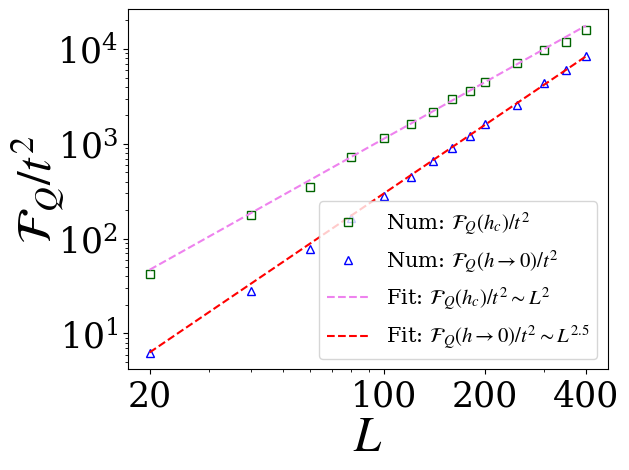

In [81]:
fig= plt.figure()
axes2= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes2.plot(Num, np.array(MaxQFIh0N)/T**2,'s', markerfacecolor='none', color='darkgreen',label='Num: $\mathcal{F}_{Q}(h_{c})/t^2$')
axes2.plot(Num, np.array(frsQFIh0N)/T**2,'^', markerfacecolor='none',color='blue',label='Num: $\mathcal{F}_{Q}(h \\rightarrow 0)/t^2$')
x_fit = np.array(Num);
plt.plot(x_fit,aNMax* x_fit**bNMax, '--', color='violet', label='Fit: $\mathcal{F}_{Q}(h_{c})/t^2\\sim L^{2}$' )
plt.plot(x_fit,aNfrs* x_fit**bNfrs, '--', color='red', label='Fit: $\mathcal{F}_{Q}(h \\rightarrow 0)/t^2\\sim L^{2.5}$' )

plt.xscale('log')
plt.yscale('log')
axes2.set_xticks([20, 100, 200,400])                      
axes2.set_xticklabels([20, 100, 200,400]) 

plt.xlabel("$L$",fontsize=35, labelpad=0)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=35, labelpad=-7)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

axes2.legend(loc='lower right', fontsize='15')

plt.show()

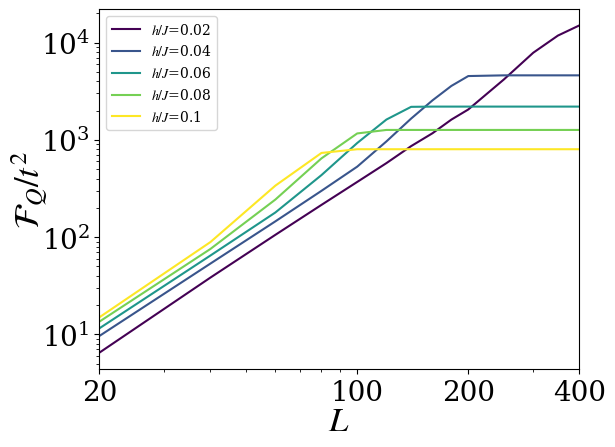

In [93]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes1.plot(Num,QFIh0N[:,9]/T**2,'-',label='$h/J$=0.02', color=colors[0])
axes1.plot(Num,QFIh0N[:,12]/T**2,'-',label='$h/J$=0.04', color=colors[5])
axes1.plot(Num,QFIh0N[:,14]/T**2,'-',label='$h/J$=0.06', color=colors[10])
axes1.plot(Num,QFIh0N[:,16]/T**2,'-',label='$h/J$=0.08', color=colors[15])
axes1.plot(Num,QFIh0N[:,18]/T**2,'-',label='$h/J$=0.1', color=colors[19])

plt.xscale('log')
plt.yscale('log')
plt.xlim(20,400)
axes1.set_xticks([20, 100, 200,400])                      
axes1.set_xticklabels([20, 100, 200,400]) 

# Naming the x-axis, y-axis 1and the whole graph
plt.xlabel("$L$",fontsize=25, labelpad= -2)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=25, labelpad=-7)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
axes1.legend(loc='upper left', fontsize= '10')
# plt.rcParams['font.size'] = '10'
plt.show()


In [94]:
n_site= 31;
Num100= np.linspace(95,105,n_site)
Num200= np.linspace(185,215,n_site)
Num300= np.linspace(285,315,n_site)

h02=np.linspace(.01,.1,37)
n_h0=37

In [98]:
QFIh0N100 = np.zeros((n_site,n_h0))
QFIh0N200 = np.zeros((n_site,n_h0))
QFIh0N300 = np.zeros((n_site,n_h0))
for nu in range(0,n_site):
        for el0 in range(0,n_h0):
                QFI= SP_timeQFI(int(Num100[nu]),J,h02[el0],d_h0,t,N_t)
                QFIh0N100[nu,el0]= QFI
                QFI= SP_timeQFI(int(Num200[nu]),J,h02[el0],d_h0,t,N_t)
                QFIh0N200[nu,el0]= QFI
                QFI= SP_timeQFI(int(Num300[nu]),J,h02[el0],d_h0,t,N_t)
                QFIh0N300[nu,el0]= QFI
                # print('nu=',nu, 'el0=', el0)

In [160]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num100;
aBeta100=np.zeros(n_h0)
bBeta100=np.zeros(n_h0)
for nu in range(0,n_h0):
    fitplot , _ = curve_fit(fitting,x_fit,np.array(QFIh0N100[:,nu])/T**2);
    aBeta100[nu],bBeta100[nu] = fitplot
# print(bBeta100)

[2.53535106e+00 2.44795927e+00 2.48351116e+00 2.42036854e+00
 2.46330534e+00 2.43523332e+00 2.46530302e+00 2.44921936e+00
 2.46879858e+00 2.53739257e+00 2.57020375e+00 2.66625017e+00
 2.84056470e+00 3.09304110e+00 3.34751943e+00 3.48602548e+00
 3.51771643e+00 3.50305151e+00 3.43674991e+00 3.36168849e+00
 3.25833945e+00 3.17719204e+00 3.07626699e+00 2.96415749e+00
 2.83760316e+00 2.69109490e+00 2.48580224e+00 2.10941321e+00
 1.57074429e+00 9.91012935e-01 5.16189807e-01 2.19825646e-01
 9.05114518e-02 3.17915502e-02 1.04979568e-02 3.60702063e-03
 1.10360469e-03]


In [161]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num200;
aBeta200=np.zeros(n_h0)
bBeta200=np.zeros(n_h0)
for nu in range(0,n_h0):
    fitplot , _ = curve_fit(fitting,x_fit,np.array(QFIh0N200[:,nu])/T**2);
    aBeta200[nu],bBeta200[nu] = fitplot
# print(bBeta200)

[ 2.42793647e+00  2.40208918e+00  2.42981061e+00  2.49380092e+00
  2.77208881e+00  3.33194054e+00  3.48967202e+00  3.39204491e+00
  3.20086326e+00  3.00661734e+00  2.83051885e+00  2.44233522e+00
  1.42036915e+00  3.75246115e-01  3.00123250e-02  5.63250300e-04
  3.79681688e-06  8.44298685e-09  2.50766447e-08 -2.88049841e-08
 -1.05895933e-08  1.63669817e-08 -1.98229791e-08 -3.93144800e-08
 -1.99052682e-08 -1.84809595e-08 -9.31555220e-09  3.41378086e-08
 -2.57295611e-08 -2.45648058e-08 -3.18716020e-08 -5.81441034e-10
 -2.75984789e-08 -2.24540618e-08 -2.50592624e-08  2.72465393e-11
 -2.07101348e-08]


/home/user/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [162]:
def fitting(x,a,b):
    return a* x**b 
x_fit = Num300;
aBeta300=np.zeros(n_h0)
bBeta300=np.zeros(n_h0)
for nu in range(0,n_h0):
    fitplot , _ = curve_fit(fitting,x_fit,np.array(QFIh0N300[:,nu])/T**2);
    aBeta300[nu],bBeta300[nu] = fitplot
# print(bBeta300)

[ 2.36679147e+00  2.48655733e+00  3.27554598e+00  3.35296828e+00
  3.09105828e+00  2.78926679e+00  2.40898561e+00  6.09459509e-01
  1.59814513e-03 -1.16359757e-08 -1.77982953e-08 -4.44772162e-08
 -3.84596020e-08 -3.91713582e-08 -3.17882649e-08 -3.39078430e-08
  6.01374598e-09 -3.14768551e-08 -3.17346036e-08 -4.69364921e-08
  4.33270238e-09 -3.37755310e-08 -3.71674370e-08 -2.80481800e-08
 -2.40376755e-08 -2.46812794e-08 -3.69545350e-08 -3.19052281e-08
 -2.91283177e-08 -3.28739114e-08 -3.83180011e-08 -6.00014029e-08
 -3.55925094e-08 -2.58773426e-08 -3.05612644e-08 -1.61290583e-08
 -3.02640979e-08]


In [352]:
ytr8= np.linspace(0,3,10);
xtr8= 8*np.ones(10)

xtr2= np.linspace(2,9,10);
ytr2= 2*np.ones(10)

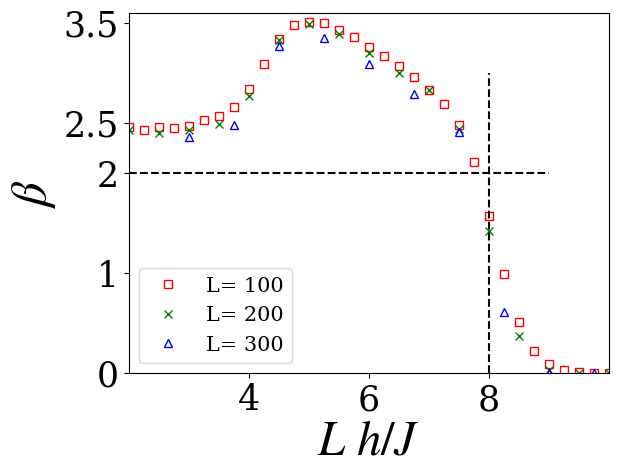

In [356]:
fig= plt.figure()
axes2= fig.add_axes([0.2, 0.2, 0.75, 0.75])

axes2.plot(h02*100,bBeta100,'s', markerfacecolor='none', color='r', label= 'L= 100')
axes2.plot(h02*200,bBeta200,'x', markerfacecolor='none',color='g', label= 'L= 200')
axes2.plot(h02*300,bBeta300,'^', markerfacecolor='none',color='b', label= 'L= 300')
plt.xlabel('$L~h/J$',fontsize=35, labelpad=0)
plt.ylabel('$\\beta$',fontsize=35)
# plt.xscale('log')
plt.xlim(2,10)
plt.ylim(0,3.6)
axes2.set_xticks([4,6,8])                      
axes2.set_xticklabels([4,6,8])
axes2.set_yticks([0,1,2,2.5,3.5])                      
axes2.set_yticklabels([0,1,2,2.5,3.5])

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
axes2.legend(loc='lower left', fontsize= '15')

plt.plot(xtr8,ytr8,'--',color= 'k')
plt.plot(xtr2,ytr2,'--',color= 'k')

plt.show()


## Population
$P_l(t)= |\braket{l|\Psi_{h0}(t)}|^2$


In [99]:
N = 100;
J = -1; delta_t= 1; T= 100; N_t= int(T/delta_t);
t= np.linspace(0,T,N_t+1);

In [105]:
h0 =.01;
Psi_t_01=np.array(SP_timePsi(N,J,h0,t, N_t));
h0 =.08;
Psi_t_08=np.array(SP_timePsi(N,J,h0,t, N_t));
h0 =.5;
Psi_t_5=np.array(SP_timePsi(N,J,h0,t, N_t));

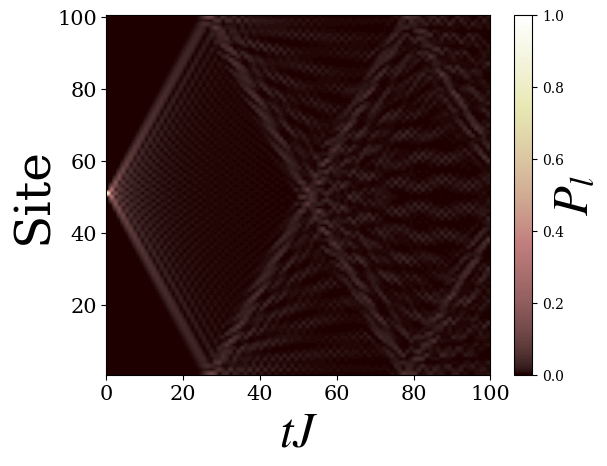

In [107]:
fig= plt.figure()
axes= fig.add_axes([0.2, 0.2, 0.75, 0.75])
im = axes.imshow(np.abs(np.transpose(Psi_t_01).conj()*np.transpose(Psi_t_01)), interpolation='bilinear', origin='lower',
               cmap=cm.pink, extent=[0, T, 0.5, N+.5], vmin=0, vmax= 1, aspect='auto')
# im = axes.imshow(np.abs(Psi_t_08.conj()*Psi_t_08), interpolation='bilinear', origin='lower',
#                cmap=cm.pink, extent=[0, T, 0.5, N+.5], vmin=0, vmax= 1, aspect='auto')
# im = axes.imshow(np.abs(Psi_t_5.conj()*Psi_t_5), interpolation='bilinear', origin='lower',
#                cmap=cm.pink, extent=[0, T, 0.5, N+.5], vmin=0, vmax= 1, aspect='auto')

plt.xlim(0,100)

plt.xlabel('$tJ$',fontsize=35)
plt.ylabel('Site',fontsize=35, labelpad=0)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

cbar= fig.colorbar(im, orientation='vertical',  shrink=1)
cbar.set_label('$P_l$',size=35, labelpad=-10)
# cbar.ax.tick_params(labelsize=15)
plt.show()


## CFI
$\mathcal{F}_{C}(h)= \sum_{x} \frac{1}{p_x(h) }(\frac{d p_x}{dh})^2$

In [5]:
# Unitary time evolution CFI
def SP_timeCFI(N,J,h0,d_h0,t,N_t):
    Psi_t = SP_timePsi(N,J,h0,t,N_t)
    d_Psi_t = SP_timePsi(N,J,h0+d_h0,t,N_t)
    CFI_t= np.zeros(N_t);
    for ti in range(N_t):
        P= (Psi_t[ti].conj()*Psi_t[ti])
        # print(P)
        d_P= (d_Psi_t[ti].conj()*d_Psi_t[ti])
        # print(d_P)
        devP= (d_P-P)/d_h0

        CFI_t[ti]= sum(1/P[i] *devP[i].conj()* devP[i] for i in range(0,N))

    return CFI_t


In [78]:
J=-1;
T=500; delta_t= 1;  N_t= int(T/delta_t)
t=np.linspace(1,T,N_t)


In [76]:
# For comparing the CFI with the QFI 
n0=np.linspace(0,.009,10); n1=np.linspace(.01,.1,10); n2= np.linspace(.15,.5,8);n3= np.linspace(.52,1,25);
n4= np.linspace(2,5,4);
h0= np.zeros(57);h0[0:10]=n0; h0[10:20]= n1; h0[20:28]= n2; h0[28:53]=n3; h0[53:57]= n4;
n_h0= 57

#For comparing dh Baysian estimation with Cramer-Rao bound
# h0= np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
# n_h0= 10;

d_h0= .0000001

In [82]:
N= 16
CFIh016 = np.zeros(n_h0,complex)
for el0 in range(0,n_h0):
        CFI_t= SP_timeCFI(N,J,h0[el0],d_h0,t,N_t) 
        CFIh016[el0]= np.mean(CFI_t[100:]/t[100:]**2) 

/tmp/ipykernel_2662/20155071.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  CFI_t[ti]= sum(1/P[i] *devP[i].conj()* devP[i] for i in range(0,N))


In [83]:
T=500; t=np.linspace(500,T,1);
N_t= 1
N=16
QFIh016 = np.zeros(n_h0)
for el0 in range(0,n_h0):
    QFI= SP_timeQFI(N,J,h0[el0],d_h0,t,N_t)
    QFIh016[el0]= QFI[N_t-1]
# print('nu=',nu)


/home/hassan/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hassan/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


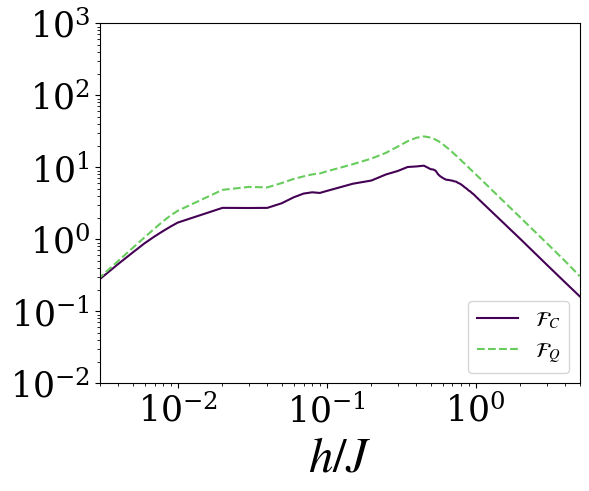

In [84]:
colors = plt.colormaps.get_cmap('viridis').resampled(14).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])


plt.plot(h0,CFIh016, label='$\mathcal{F}_{C}$', color=colors[0])
plt.plot(h0,QFIh016/T**2, '--', label='$\mathcal{F}_{Q}$', color=colors[10])

plt.xscale('log')
plt.yscale('log')
plt.xlim(.003,5)
plt.ylim(.01,1000)
plt.xlabel("$h/J$",fontsize=35)

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# ax.set_yticks([.1,.2])
# plt.tick_params(labelcolor='r', labelsize='medium', width=10)

#plt.title("")

plt.legend(loc='lower right', fontsize= '15')
#plt.rcParams['font.size'] = '10'
plt.show()


/home/hassan/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hassan/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


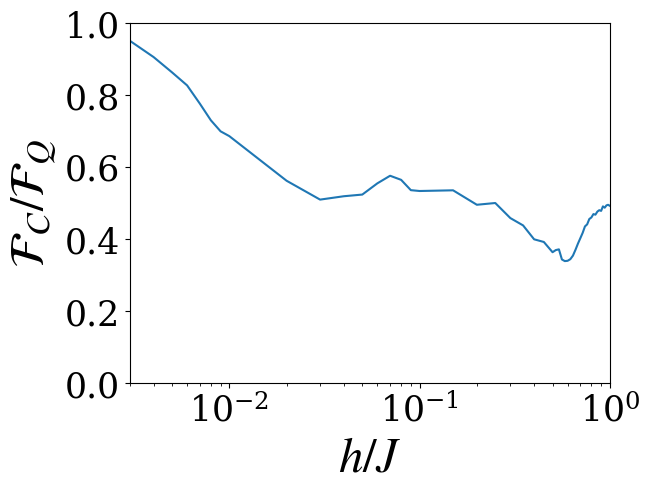

In [86]:
colors = plt.colormaps.get_cmap('viridis').resampled(14).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])


plt.plot(h0,CFIh016/(QFIh016/T**2))

plt.xscale('log')
# plt.yscale('log')
plt.xlim(.003,1)
plt.ylim(0,1)
plt.xlabel("$h/J$",fontsize=35)
plt.ylabel("$\mathcal{F}_{C}/\mathcal{F}_{Q}$",fontsize=35)


plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# ax.set_yticks([.1,.2])
# plt.tick_params(labelcolor='r', labelsize='medium', width=10)

plt.show()


## Beyasian

In [9]:
def SP_time_Bayesian(N,J,h0,n_h0,h0_es,M):
    # initial state
    Psi_0_t=np.zeros(N);
    m= int(N/2);
    Psi_0_t[m]=1;

    # probability of position measurement
    p=np.zeros((N,n_h0));
    for i_h in range(n_h0):
        H= SP_hamiltonian(N,J,h0[i_h])
        Psi_t= np.dot(expm(-1j*H*T),Psi_0_t);
        p[:,i_h]= abs(np.transpose(Psi_t).conj()*Psi_t)
    
    # probability of the real value
    H= SP_hamiltonian(N,J,h0_es);
    Psi_t_es= np.dot(expm(-1j*H*T),Psi_0_t);
    p_es= np.transpose(Psi_t_es).conj()*Psi_t_es
    
    # outcome
    max_M= []; mean_M= []; var_M= [];
    # repetitions
    for n in range(100):
        # Measurement of Lattice     
        n_l= np.zeros(N)
        for i_m in range(M):
            r= choice(N,1,p=abs(p_es))
            n_l[r]+= 1

        # likelihood
        One= np.ones(n_h0);
        P_h0= np.ones(n_h0) / n_h0
        likelihood=One;
        for i_N in range(N):
            likelihood= likelihood * binom(M,n_l[i_N]) * p[i_N,:]**n_l[i_N]

        # normalization factor
        evidence = np.sum(likelihood * P_h0 * dh0)
        # posterior probability distribution
        P_h0= likelihood*P_h0/evidence

        Mean= sum(h0[i_h] * P_h0[i_h] * dh0 for i_h in range(n_h0))
        Var= sum((h0[i_h]-Mean)**2 * P_h0[i_h] * dh0 for i_h in range(n_h0))
               
        mean_M.append(Mean)
        var_M.append(Var)

        max_M.append(np.argmax(P_h0))

    muMax= np.mean(h0[max_M])
    varMax= np.var(h0[max_M])

    mu= np.mean(mean_M)
    var= np.mean(var_M)
    
    return mu, var, muMax , varMax


In [10]:
J=-1;
T=500; delta_t= 1;  N_t= int(T/delta_t)
t=np.linspace(1,T,N_t)

In [19]:
N= 16;
h0_es= [.1,.2,.3,.4,.5,.6,.7,.8,.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
n_es= 46

M=100
mu_h0= []; muMax_h0= []; var_h0= []; varMax_h0= []
for i_hes in range(0,n_es):
    n_h0_b= 21
    h0_b= np.linspace(h0_es[i_hes]-.001, h0_es[i_hes]+.001,n_h0_b)
    dh0= h0_b[1]-h0_b[0]

    mu, Var, muMax, varMax= SP_time_Bayesian(N,J,h0_b,n_h0_b,h0_es[i_hes],M)

    mu_h0.append(mu)
    var_h0.append(np.mean(Var))
    muMax_h0.append(muMax)
    varMax_h0.append(varMax)   


M=  100


In [20]:
    var_h0_100= var_h0
    varMax_h0_100= varMax_h0
    mu_100= mu_h0
    muMax_100= muMax_h0

In [15]:
n= 10; h0= np.linspace(.1,1,n)
CFIh016 = np.zeros(n_h0,complex)
for el0 in range(0,n_h0):
        CFI_t= SP_timeCFI(N,J,h0[el0],d_h0,t,N_t) 
        CFIh016[el0]= np.mean(CFI_t[100:]/t[100:]**2) 

/tmp/ipykernel_2662/20155071.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  CFI_t[ti]= sum(1/P[i] *devP[i].conj()* devP[i] for i in range(0,N))


/home/hassan/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hassan/anaconda3/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


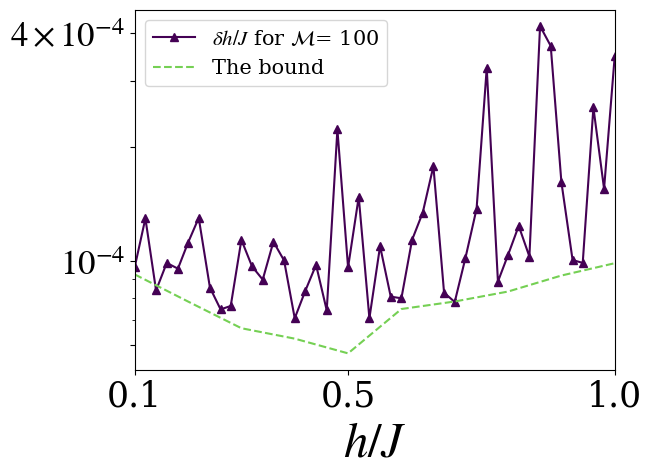

In [21]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(h0_es, np.sqrt(varMax_h0_100), '^-', label= '$\delta h/J$ for $\mathcal{M}$= 100', color= colors[0])
plt.plot(h0,1/np.sqrt(100*CFIh016*T**2), '--', color= colors[15], label= 'The bound')

plt.yscale('log')
plt.xlim(.1,1)

plt.xlabel("$h/J$",fontsize=35)
axes1.yaxis.set_label_coords(-.1, .65)
axes1.set_xticks([.1, .5, 1])
axes1.set_yticks([6e-5, 1e-4, 2e-4, 3e-4, 4e-4])
axes1.set_yticklabels(['','$10^{-4}$','', '', '$4 \\times 10^{-4}$'])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left', fontsize= '15')
#plt.rcParams['font.size'] = '10'

plt.show()


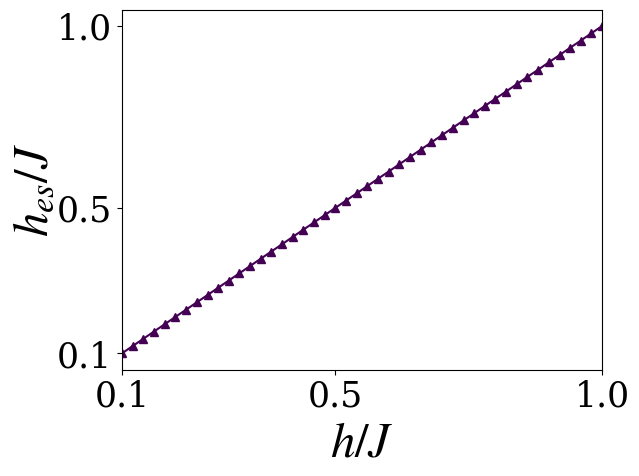

In [22]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(h0_es, muMax_100, '^-', color= colors[0])

plt.xlim(.1,1)

plt.xlabel("$h/J$",fontsize=35)
plt.ylabel("$h_{es}/J$", fontsize=35, labelpad= 0)
axes1.set_yticks([.1, .5, 1])
axes1.set_xticks([.1, .5, 1])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.show()


## Decoherence
$ \mathcal{F}_{Q}(h)= 2 \sum_{nm} \frac{\braket{\Psi_m|\partial_h \rho_h|\Psi_n}}{\rho_n +\rho_m}$ 

In [6]:
# calculation the QFI under the enfluence of the decoherence
def QLindbladQFI(N,J,h0,t,gamma):
    # initial state
    psi=np.zeros(N);
    m= int(N/2);
    psi[m]=1;
    Psi_0_t= Qobj(psi)
    
    H= Qobj(SP_hamiltonian(N, J, h0))

    # solving the master equation
    I= np.eye(N)
    c=np.zeros((N,N));
    C=[]
    for i_m in range(N):
        c[i_m,i_m]=1
        C.append(Qobj(-2*gamma*c+I))
    results= mesolve(H,Psi_0_t,t,C,[])
    rho_t= results.states
    d_H= Qobj(SP_hamiltonian(N, J, h0+d_h0))
    results= mesolve(d_H,Psi_0_t,t,C,[])
    d_rho_t= results.states

    # calculation of the QFI
    Dev_rho_t= (np.array(d_rho_t)-np.array(rho_t))/d_h0
    QFI_t= []; CFI_t= []
    for i_t in range(N_t):
        eigval, eigvec= eigh(rho_t[i_t].full())

        QFI=0;
        for n in range(N):
            for m in range(N):
                if eigval[n]+eigval[m]>=1e-15:
                    QFI+= 2*(abs(np.dot(eigvec[:,m].transpose().conj(), np.dot(Dev_rho_t[i_t].full(), eigvec[:,n]))**2/(eigval[m]+eigval[n])))
                    
        QFI_t.append(QFI)

    return rho_t, QFI_t

In [16]:
J = -1; 
delta_t = 1; T = 200;
N_t= int(T/delta_t+1); t_d=np.linspace(0,T,N_t);

In [17]:
N=6;
d_h0=1e-5;

gamma=np.sqrt(.005)
h0= .1; 
rho_t, QQFI_t_h1_g005= QLindbladQFI(N,J,h0,t_d,gamma)
h0= .5;
rho_t, QQFI_t_h5_g005= QLindbladQFI(N,J,h0,t_d,gamma)
h0= 1;
rho_t, QQFI_t_h10_g005= QLindbladQFI(N,J,h0,t_d,gamma)


/tmp/ipykernel_3543/1284532953.py:5: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h1_g005/t_d**2, color=colors[0], markevery=100, label='$h/J= 0.1$')
/tmp/ipykernel_3543/1284532953.py:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h5_g005/t_d**2, color=colors[10], markevery=100, label='$h/J= 0.5$')
/tmp/ipykernel_3543/1284532953.py:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h10_g005/t_d**2, color=colors[17], markevery=100, label='$h/J= 1$')


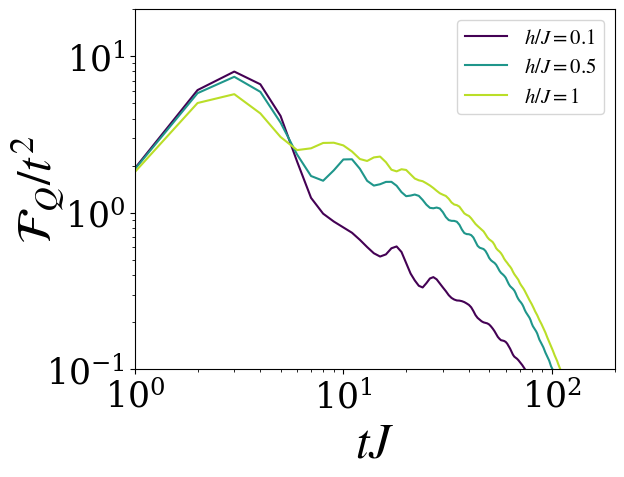

In [18]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(t_d,QQFI_t_h1_g005/t_d**2, color=colors[0], markevery=100, label='$h/J= 0.1$')
plt.plot(t_d,QQFI_t_h5_g005/t_d**2, color=colors[10], markevery=100, label='$h/J= 0.5$')
plt.plot(t_d,QQFI_t_h10_g005/t_d**2, color=colors[17], markevery=100, label='$h/J= 1$')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1,200)
plt.ylim(0.1,20)

plt.xlabel("$tJ$",fontsize=35)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=35, labelpad= -15)
# axes1.set_yticks([0, 15, 30])
# axes1.set_yticklabels(['$0$','$10^{3}$',' $2 \\times 10^{3}$'])
# axes1.set_xticks([50, 100])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# ax.set_yticks([.1,.2])
# plt.tick_params(labelcolor='r', labelsize='medium', width=10)

#plt.title("")

plt.legend(loc='upper right', fontsize= '15')
# plt.rcParams['font.size'] = '10'

plt.show()

In [ ]:
delta_t = .1; T = 100;
N_t= int(T/delta_t); t_d=np.linspace(1,T,N_t);

In [ ]:
N=16;
d_h0=1e-11;
h0= .1;
gamma=np.sqrt(.005)
rho_t, QQFI_t_h1_g005= QLindbladQFI(N,J,h0,t_d,gamma)
gamma=np.sqrt(.01)
rho_t, QQFI_t_h1_g01= QLindbladQFI(N,J,h0,t_d,gamma)
gamma=np.sqrt(.05)
rho_t, QQFI_t_h1_g05= QLindbladQFI(N,J,h0,t_d,gamma)

In [ ]:
N = 16; 
d_h0=.00001;
h0 =.1;
QFI_161 = SP_timeQFI(N,J,h0,d_h0,t,N_t)

/tmp/ipykernel_2794/948911316.py:17: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h1_g005/t_d**2, color=colors[0], markevery=100, label='$\gamma/J= 0.005$')
/tmp/ipykernel_2794/948911316.py:20: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h1_g01/t_d**2, color=colors[10], markevery=100, label='$\gamma/J= 0.01$')
/tmp/ipykernel_2794/948911316.py:22: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t_d,QQFI_t_h1_g05/t_d**2, color=colors[17], markevery=100, label='$\gamma/J= 0.05$')
/tmp/ipykernel_2794/948911316.py:28: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(t,QFI_161/t**2, '--', label='$\gamma/J= 0$', color='k')


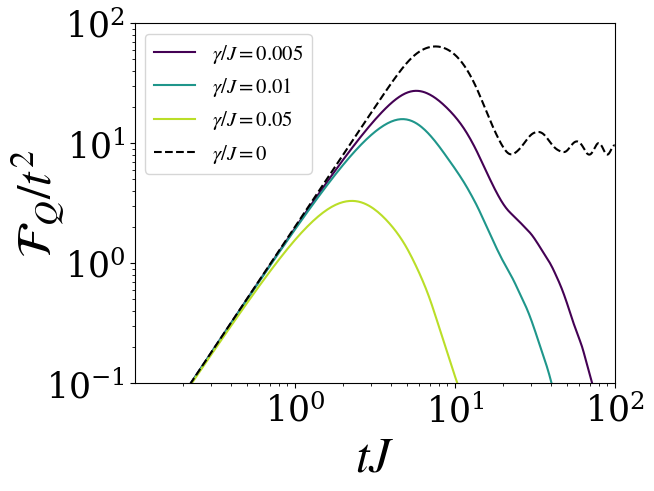

In [34]:
colors = plt.colormaps.get_cmap('viridis').resampled(20).colors
fig= plt.figure()
axes1= fig.add_axes([0.2, 0.2, 0.75, 0.75])

plt.plot(t_d,QQFI_t_h1_g005/t_d**2, color=colors[0], markevery=100, label='$\gamma/J= 0.005$')
plt.plot(t_d,QQFI_t_h1_g01/t_d**2, color=colors[10], markevery=100, label='$\gamma/J= 0.01$')
plt.plot(t_d,QQFI_t_h1_g05/t_d**2, color=colors[17], markevery=100, label='$\gamma/J= 0.05$')

plt.plot(t,QFI_161/t**2, '--', label='$\gamma/J= 0$', color='k')

plt.xscale('log')
plt.yscale('log')
plt.xlim(.1,100)
plt.ylim(0.1,100)

plt.xlabel("$tJ$",fontsize=35)
plt.ylabel("$\mathcal{F}_{Q}/t^2$", fontsize=35, labelpad= -15)
axes1.set_xticks([1, 10, 100])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc='upper left', fontsize= '15')

plt.show()
